# ResNet

- **Training set**: LO_SARD102
- **Test/Validation set:** JTT
- **Features**: word2vec sequence (100)
- **Class imbalance processing**: weights

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report

X_train = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD_w2vseq_X_full_train.npy', mmap_mode='r')
Y_train = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD_w2vseq_Y_full_train.npy', mmap_mode='r')

X_val = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD_w2vseq_X_full_val.npy', mmap_mode='r')
Y_val = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD_w2vseq_Y_full_val.npy', mmap_mode='r')

X_test =  numpy.load('/mnt/md0/user/scheuererra68323/JTT_w2vseq_X.npy',  mmap_mode='r')
Y_test =  numpy.load('/mnt/md0/user/scheuererra68323/JTT_w2vseq_Y.npy',  mmap_mode='r')

classWeights = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD_w2vseq_weights_full_train.npy')
classWeights = { 0: classWeights[0], 1: classWeights[1] }
print(f"class weights: {classWeights}\n")

print("Y_train:")
print(Counter(Y_train))
print(X_train.shape)
print(Y_train.shape)

print("\nY_val:")
print(Counter(Y_val))
print(X_val.shape)
print(Y_val.shape)

print("\nY_test:")
print(Counter(Y_test))
print(X_test.shape)
print(Y_test.shape)

train_gen = ResNetDataGenerator(_X=X_train, _y=Y_train, batch_size=512)
val_gen =   ResNetDataGenerator(_X=X_val,   _y=Y_val,   batch_size=512)
test_gen =  ResNetDataGenerator(_X=X_test,  _y=Y_test,  batch_size=512)

class weights: {0: 0.5201141550723843, 1: 12.929057999221486}

Y_train:
Counter({0.0: 31975, 1.0: 1240})
(33215, 100, 100)
(33215,)

Y_val:
Counter({0.0: 31975, 1.0: 1240})
(33215, 100, 100)
(33215,)

Y_test:
Counter({0.0: 21243, 1.0: 608})
(21851, 100, 100)
(21851,)


## Build & train keras model

In [2]:
# https://keras.io/api/applications/resnet/#resnet50-function
model = applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(100, 100, 1),
    pooling=None,
    classes=2
)

sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.95)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

history = model.fit(train_gen,
                    epochs=8,
                    verbose=True,
                    validation_data=val_gen,
                    class_weight=classWeights
                   )

Epoch 1/8
65/65 [==============================] - 42s 647ms/step - loss: 2.7692 - accuracy: 0.5906 - val_loss: 62684405956608.0000 - val_accuracy: 0.9627
Epoch 2/8
65/65 [==============================] - 41s 629ms/step - loss: 0.6752 - accuracy: 0.5478 - val_loss: 76198816.0000 - val_accuracy: 0.9627
Epoch 3/8
65/65 [==============================] - 41s 631ms/step - loss: 0.6699 - accuracy: 0.4962 - val_loss: 199563.1094 - val_accuracy: 0.9627
Epoch 4/8
65/65 [==============================] - 41s 631ms/step - loss: 0.6741 - accuracy: 0.5360 - val_loss: 652.1354 - val_accuracy: 0.9622
Epoch 5/8
65/65 [==============================] - 41s 630ms/step - loss: 0.6751 - accuracy: 0.4906 - val_loss: 0.7172 - val_accuracy: 0.2905
Epoch 6/8
65/65 [==============================] - 41s 630ms/step - loss: 0.6604 - accuracy: 0.4902 - val_loss: 0.6756 - val_accuracy: 0.2475
Epoch 7/8
65/65 [==============================] - 41s 630ms/step - loss: 0.6299 - accuracy: 0.5997 - val_loss: 0.2650 - 

## Evaluation

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     21243
         1.0       0.00      0.00      0.00       608

    accuracy                           0.97     21851
   macro avg       0.49      0.50      0.49     21851
weighted avg       0.95      0.97      0.96     21851

Confusion matrix:
[[21243     0]
 [  608     0]]

Confusion matrix (Percentages):
[[97.218  0.   ]
 [ 2.782  0.   ]]

Metrics:
Sensitivity (TPR): 0.000000
Specifity (TNR):   1.000000

FPR: 0.000000
FNR: 1.000000

Balanced accuracy: 0.500000

Test loss:	0.172545
Test accuracy:	0.972175


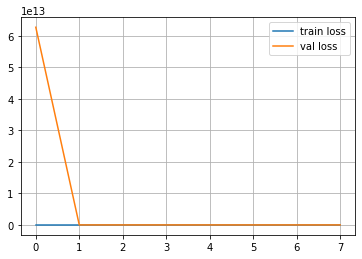

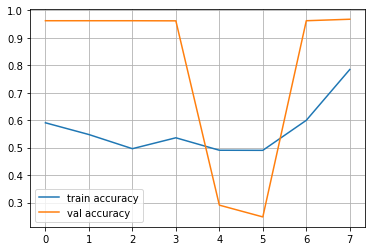

In [3]:
Y_pred = numpy.argmax( model.predict(test_gen) , axis=1 )

print(classification_report(Y_test, Y_pred))
print_metrics(confusion_matrix(Y_test, Y_pred), Y_test)
print()
score = model.evaluate(test_gen, verbose=False)
print('Test loss:\t{:.6f}'.format(score[0]))
print('Test accuracy:\t{:.6f}'.format(score[1]))

plot_loss(history)
plot_accuracy(history)

In [5]:
model.save('testJTT_ResNet_word2vec_weighted.h5')